In [1]:
%load_ext autoreload
%autoreload 2

import sys, os
project_root = os.path.abspath("../..")  # one level up from /notebooks
if project_root not in sys.path:
    sys.path.append(project_root)

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import fftconvolve
from src.image_generation import moffat, sersic
from src.analysis import gaussian_weight, wiener_deconvolution, calculate_gaap_flux
from scipy.ndimage import shift
import matplotlib as mpl
from photutils.segmentation import detect_threshold, detect_sources
from photutils.centroids import centroid_com
from photutils.segmentation import deblend_sources
from scipy.spatial import cKDTree
from scipy.stats import norm
from numpy.fft import fft2, ifft2, fftshift
import importlib
from tqdm import tqdm

In [ ]:
# Set plot parameters
mpl.rcParams['image.cmap'] = 'grey'
mpl.rcParams['image.origin'] = 'lower'

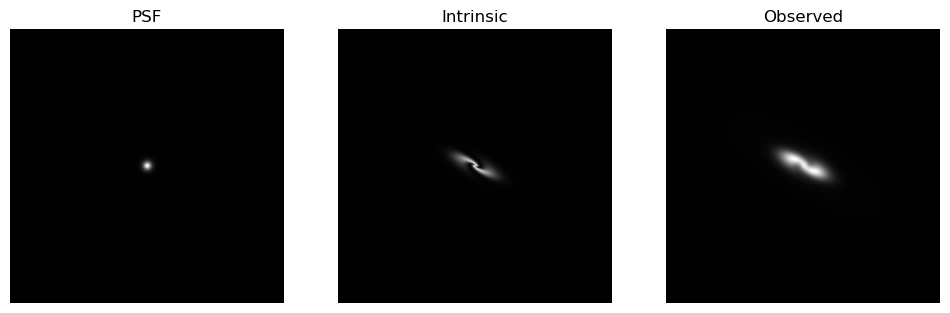

In [4]:
width = 400
height = 400

# Create PSF and Galaxy images
image_psf = moffat(width, height, 3.5, 10)
image_intrinsic = sersic(width, height, height / 2, width / 2, k=1.5, n=4, inclination=np.radians(70),
                         rotation=np.radians(30), n_arms=2, bulge_strength=1, Rc=30)

# Convolve the galaxy with the PSF
image = fftconvolve(image_intrinsic, image_psf, mode="same")

# Plot
fig, axs = plt.subplots(1, 3, figsize=(12, 8))
axs[0].imshow(image_psf, extent=(0, width, 0, height))
axs[0].set_title("PSF")
axs[1].imshow(image_intrinsic, extent=(0, width, 0, height))
axs[1].set_title("Intrinsic")
axs[2].imshow(image, extent=(0, width, 0, height))
axs[2].set_title("Observed")
plt.show()

In [5]:
# Define weight function
weight = gaussian_weight(height, width, height / 2, width / 2, 20, 20)
weight_low_res = gaussian_weight(height//2, width//2, height / 4, width / 4, 10, 10)

# Calculate the aperture flux using the intrinsic image and weight function
true_F = np.sum(weight * image_intrinsic)
print(f'The aperture flux measured using the intrinsic image and weight function : {true_F:.6f}')

# Calculate the aperture flux using the observed image and rescaled weight function
measured_F, sigma_F = calculate_gaap_flux(image, image_psf, weight, [(height / 2, width / 2)])
print(f'The aperture flux using the observed image and rescaled weight function : {measured_F[0]:.6f}')

The aperture flux measured using the intrinsic image and weight function : 0.252183
The aperture flux using the observed image and rescaled weight function : 0.252183


/home/deklerk/GAAP/src/analysis.py:72: RuntimeWarning: invalid value encountered in scalar divide
  sigma = np.sqrt(np.sum(x_negative ** 2) * np.sum(weight_rescale ** 2) / len(x_negative))


/home/deklerk/GAAP/src/analysis.py:72: RuntimeWarning: invalid value encountered in scalar divide
  sigma = np.sqrt(np.sum(x_negative ** 2) * np.sum(weight_rescale ** 2) / len(x_negative))
/var/tmp/deklerk/ipykernel_1860459/3985729901.py:13: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  measured_fluxes[i]  = measured_F


0.1
0.10985411419875583
0.12067926406393285
0.13257113655901093
0.14563484775012436
0.15998587196060582
0.1757510624854792
0.193069772888325
0.21209508879201905
0.2329951810515372
0.2559547922699536
0.281176869797423
0.3088843596477481
0.3393221771895328
0.372759372031494
0.4094915062380424
0.44984326689694454
0.49417133613238345
0.5428675439323859
0.5963623316594643
0.6551285568595507
0.7196856730011519
0.7906043210907697
0.8685113737513525
0.9540954763499939
1.0481131341546859
1.151395399326447
1.2648552168552958
1.3894954943731375
1.5264179671752334
1.6768329368110073
1.8420699693267153
2.0235896477251565
2.2229964825261943
2.442053094548651
2.6826957952797246
2.9470517025518097
3.2374575428176433
3.5564803062231287
3.9069399370546147
4.291934260128776
4.714866363457392
5.17947467923121
5.689866029018296
6.25055192527397
6.866488450042998
7.543120063354615
8.286427728546842
9.102981779915218
10.0


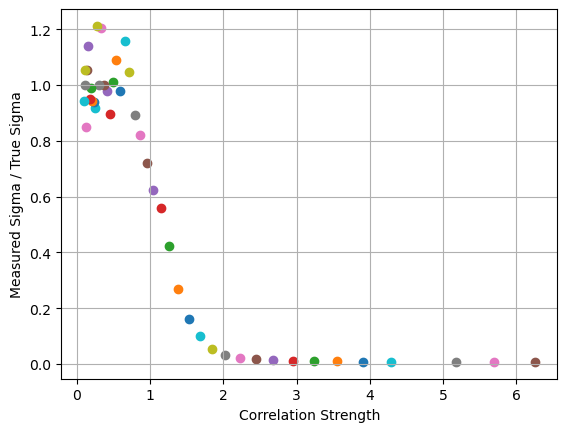

In [25]:
N = 100
measured_fluxes = np.zeros(N)
measured_sigmas = np.zeros(N)
true_F, _ = calculate_gaap_flux(image, image_psf, weight, [(height / 2, width / 2)])
true_sigma = 0.01
for a in np.logspace(-1, 1, 50):
    print(a)
    noise_psf = moffat(width, height, a, 0.1)
    for i in range(N):
        noise = np.random.normal(0, true_sigma, (width, height))
        noise = fftconvolve(noise, noise_psf, mode='same')
        measured_F, sigma_F = calculate_gaap_flux(image+noise, image_psf, weight, [(height / 2, width / 2)])
        measured_fluxes[i]  = measured_F
        measured_sigmas[i] = sigma_F
    plt.scatter(1/a, np.mean(measured_sigmas)/np.std(measured_fluxes))
plt.xlabel('Correlation Strength')
plt.ylabel('Measured Sigma / True Sigma')
plt.show()
